# Test Corr Models

In [ ]:
import pandas as pd
from copy import deepcopy

import correlation as CM
import backtesting as BT
import plots as IP
import data_download as dd

### Data 

In [3]:
# Define shares directly (tickers inferred from index)
shares = pd.Series({
    "AAPL": 10,
    "MSFT": 9,
    "NVDA": 80,
    "GOOGL": 6,
    "JPM": -9
})

# Download prices for the tickers in 'shares'
tickers = shares.index.tolist()
prices = dd.get_raw_prices(tickers, start="2024-01-01")

# Convert prices to base currency (e.g. CHF)
prices_converted = dd.convert_to_base(prices, base_currency="CHF")

# Create portfolio with monetary positions
x_matrix = dd.create_portfolio(prices_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(x_matrix)

# Display
final_value = x_matrix.sum(axis=1).iloc[-1]
print(f"\nPortfolio final value in CHF: {final_value:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] MSFT: USD
[currency detection] NVDA: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 13098.64

Sample of daily returns:
                 AAPL     GOOGL       JPM      MSFT      NVDA
Date                                                        
2024-01-03  0.002215  0.015257  0.005375  0.009041 -0.002782
2024-01-04 -0.014117 -0.019621  0.005191 -0.008602  0.007570
2024-01-05 -0.002722 -0.003550  0.006320  0.000779  0.024222
2024-01-08  0.025054  0.023792 -0.000594  0.019746  0.065195
2024-01-09 -0.005582  0.011820 -0.011206 -0.000401  0.013592

Mean returns (daily, in CHF):
 AAPL     0.000532
GOOGL    0.000740
JPM      0.001478
MSFT     0

In [4]:
x_matrix.head()

,AAPL,GOOGL,JPM,MSFT,NVDA
Date,,,,,
2024-01-02,1551.522630,694.622688,-1259.144120,2778.545401,3242.954747
2024-01-03,1554.959145,705.220420,-1265.911624,2803.665191,3233.934430
2024-01-04,1533.007736,691.383402,-1272.483486,2779.546830,3258.416930
2024-01-05,1528.834220,688.929217,-1280.525167,2781.712039,3337.342530
2024-01-08,1567.138256,705.320010,-1279.764925,2836.640769,3554.920549


In [5]:
missing_values = x_matrix.isnull().any().any()
print(f"Does x_matrix have missing values? {missing_values}")

Does x_matrix have missing values? False


In [6]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.ma_correlation_var(x_ma, distribution="empirical")

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.ewma_correlation_var(x_rm, distribution="empirical")


In [7]:
result_ma.head(-10)

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation
2024-01-31,-0.028007,0.016490,-1.698482,0.041670,344.799057,False
2024-02-01,0.022534,0.016672,1.351642,0.042130,356.482604,False
2024-02-02,0.025885,0.016721,1.548035,0.042254,366.637329,False
2024-02-05,0.034857,0.017601,1.980344,0.044479,399.100068,False
2024-02-06,-0.003063,0.015741,-0.194577,0.039779,355.798412,False
...,...,...,...,...,...,...
2025-04-29,-0.005329,0.050335,-0.105867,0.127198,1371.490873,False
2025-04-30,0.003316,0.050025,0.066296,0.126413,1367.537629,False
2025-05-01,0.040977,0.050668,0.808751,0.128038,1441.073757,False
2025-05-02,0.019351,0.048139,0.401982,0.121649,1394.956914,False


In [8]:
result_rm.head(-10)

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation
2024-01-03,0.003378,0.022927,0.147324,0.052275,367.590808,False
2024-01-04,-0.005874,0.022416,-0.262028,0.051111,357.257247,False
2024-01-05,0.009680,0.021990,0.440194,0.050139,353.796259,False
2024-01-08,0.046664,0.024290,1.921096,0.055384,408.971065,False
2024-01-09,0.008295,0.023667,0.350475,0.053962,401.770119,False
...,...,...,...,...,...,...
2025-04-29,-0.005329,0.040704,-0.130915,0.092809,1000.701661,False
2025-04-30,0.003316,0.039455,0.084056,0.089961,973.196967,False
2025-05-01,0.040977,0.039328,1.041940,0.089671,1009.250519,False
2025-05-02,0.019351,0.038538,0.502134,0.087869,1007.601370,False


In [9]:
# Apply volatility-based ES to the MA VaR result
result_ma = CM.correlation_es(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = CM.correlation_es(result_rm, confidence_level=0.99)

In [10]:
result_ma.head(-10)

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2024-01-31,-0.028007,0.016490,-1.698482,0.041670,344.799057,False,0.047115,389.858093
2024-02-01,0.022534,0.016672,1.351642,0.042130,356.482604,False,0.047636,403.068470
2024-02-02,0.025885,0.016721,1.548035,0.042254,366.637329,False,0.047776,414.550235
2024-02-05,0.034857,0.017601,1.980344,0.044479,399.100068,False,0.050291,451.255270
2024-02-06,-0.003063,0.015741,-0.194577,0.039779,355.798412,False,0.044977,402.294867
...,...,...,...,...,...,...,...,...
2025-04-29,-0.005329,0.050335,-0.105867,0.127198,1371.490873,False,0.143820,1550.720068
2025-04-30,0.003316,0.050025,0.066296,0.126413,1367.537629,False,0.142933,1546.250206
2025-05-01,0.040977,0.050668,0.808751,0.128038,1441.073757,False,0.144771,1629.396184
2025-05-02,0.019351,0.048139,0.401982,0.121649,1394.956914,False,0.137546,1577.252699


In [11]:
result_rm.head(-10)

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2024-01-03,0.003378,0.022927,0.147324,0.052275,367.590808,False,0.060417,424.841264
2024-01-04,-0.005874,0.022416,-0.262028,0.051111,357.257247,False,0.059071,412.898302
2024-01-05,0.009680,0.021990,0.440194,0.050139,353.796259,False,0.057948,408.898283
2024-01-08,0.046664,0.024290,1.921096,0.055384,408.971065,False,0.064010,472.666292
2024-01-09,0.008295,0.023667,0.350475,0.053962,401.770119,False,0.062367,464.343835
...,...,...,...,...,...,...,...,...
2025-04-29,-0.005329,0.040704,-0.130915,0.092809,1000.701661,False,0.107264,1156.556011
2025-04-30,0.003316,0.039455,0.084056,0.089961,973.196967,False,0.103972,1124.767597
2025-05-01,0.040977,0.039328,1.041940,0.089671,1009.250519,False,0.103637,1166.436312
2025-05-02,0.019351,0.038538,0.502134,0.087869,1007.601370,False,0.101554,1164.530316



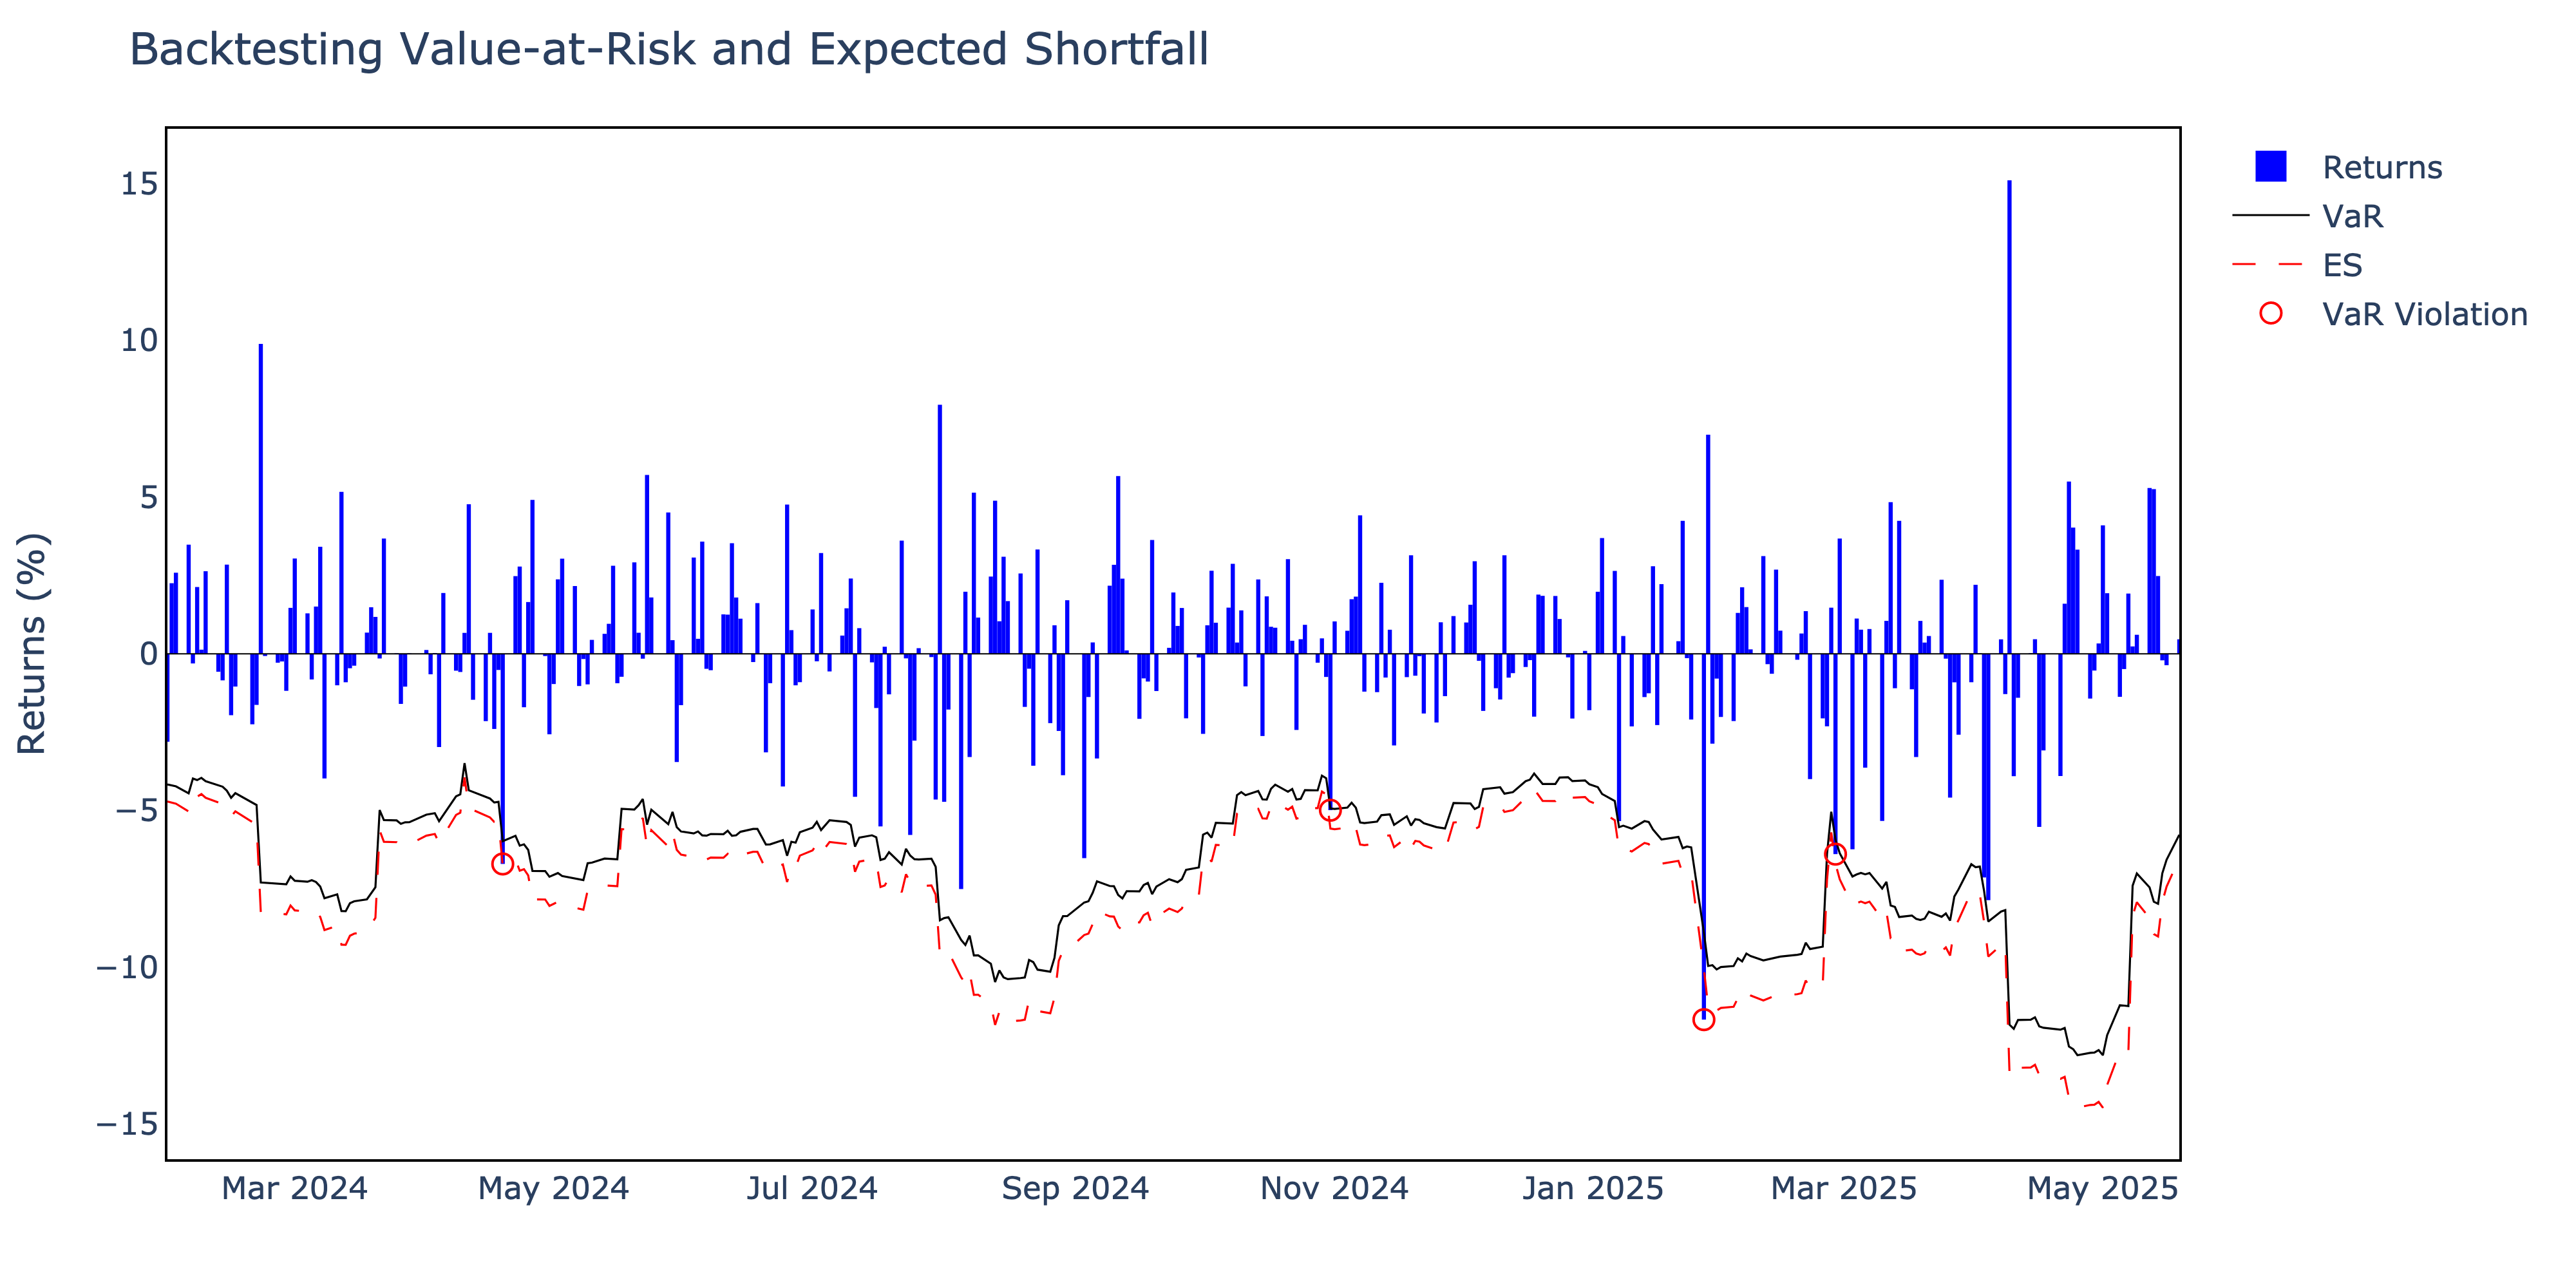


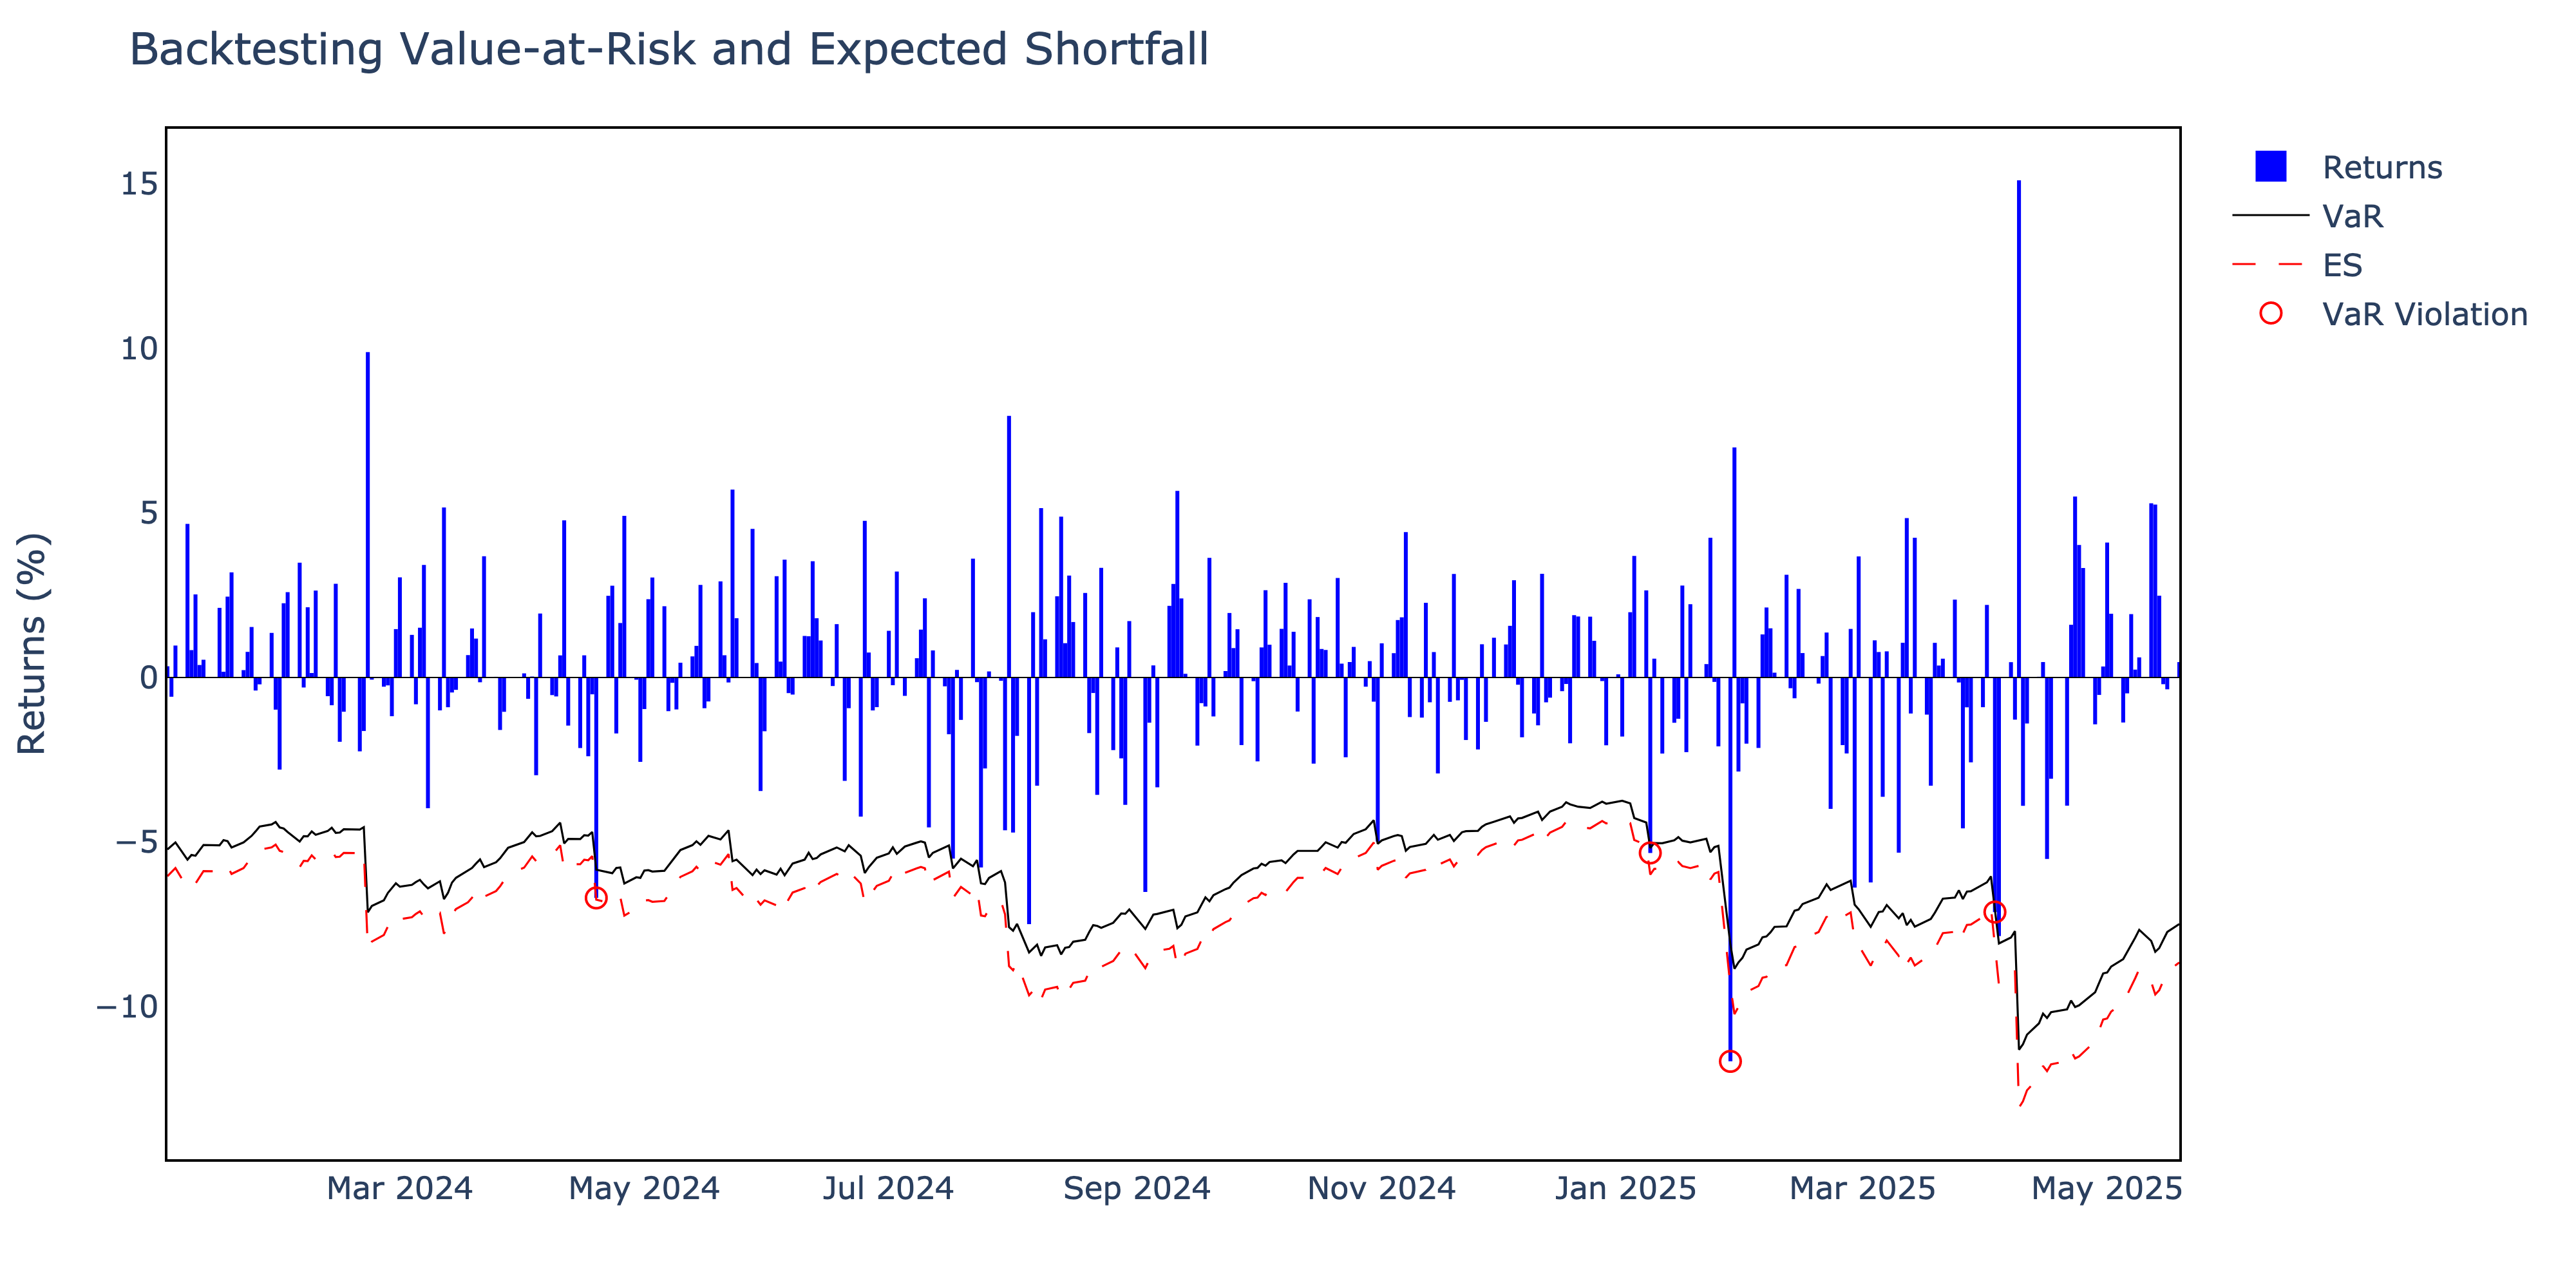

In [12]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [13]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {100*rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 4
Violation Rate: 1.23%


In [14]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {100*rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 4
Violation Rate: 1.16%


In [15]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])